In [2]:
from fastai.basics import *
from fastai.vision.all import *

from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
from collections import defaultdict
import cmasher as cmr
import matplotlib.gridspec as gridspec

ROOT = Path("..").resolve()
seed = 256

In [3]:
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap

fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Italic.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Regular.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-Bold.otf")
fm.fontManager.addfont("/Users/john/Library/Fonts/Nunito-ExtraBold.otf")

plt.rcParams['font.family'] = 'Nunito'
plt.rcParams['font.weight'] = "bold"
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.sf'] = 'Nunito'
plt.rcParams['mathtext.rm'] = 'Nunito'
plt.rcParams['mathtext.it'] = 'Nunito'
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=["#003f5c","#2f4b7c","#665191","#a05195","#d45087","#f95d6a","#ff7c43","#ffa600",])

# Top-k resnet18

In [4]:
K = 4

def RMSE(p, y): return torch.sqrt(MSELossFlat()(p, y))
    
class ResNetTopK(nn.Module):
    """Resnet18-like model with a single projection head at end, and a top-k 
    sparsity constraint in penultimate layer to encourage interpretability.
    """
    def __init__(self, k=32, n_out=1000, pretrained=True, **kwargs):
        super(ResNetTopK, self).__init__()
        if pretrained:
            self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT, **kwargs)
        else:
            self.resnet = resnet18(weights=None, **kwargs)
        self.k = k
        # change n_out features
        n_fc_in = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(n_fc_in, n_out)

    def forward(self, x):
        # regular convnet up to final layer
        features = nn.Sequential(*list(self.resnet.children())[:-1])(x)
        features = torch.flatten(features, 1)
        features = nn.functional.relu(features)
        
        # top-k constraint
        topk_values, topk_indices = torch.topk(features, k=self.k, dim=1)
        sparse_features = torch.zeros_like(features)
        sparse_features.scatter_(1, topk_indices, topk_values)
        
        # final fully connected layer
        x = self.resnet.fc(sparse_features)
        return x

In [5]:
df = pd.read_csv(ROOT / 'data/galaxies.csv', dtype={'objID': str})

df = df[
    (df.nii_6584_flux / df.nii_6584_flux_err  > 3)
    & (df.h_alpha_flux / df.h_alpha_flux_err > 3)
    & (df.oiii_5007_flux / df.oiii_5007_flux_err  > 3)
    & (df.h_beta_flux / df.h_beta_flux_err > 3)
    & (df.nii_6584_flux < 1e5)
    & (df.h_alpha_flux < 1e5)
    & (df.oiii_5007_flux < 1e5)
    & (df.h_beta_flux < 1e5)
].copy()

n_galaxies = len(df)

# set a random state
rng = np.random.RandomState(seed)

In [6]:
n_galaxies

250207

In [7]:
# new targets
df["log_N2"] = np.log10(df.nii_6584_flux)
df["log_Ha"] = np.log10(df.h_alpha_flux)
df["log_O3"] = np.log10(df.oiii_5007_flux)
df["log_Hb"] = np.log10(df.h_beta_flux)

In [8]:
# fastai "data blocks" determine how data can be fed into a model
target = ['log_N2', 'log_Ha', 'log_O3', 'log_Hb']
dblock = DataBlock(
    blocks=(ImageBlock, RegressionBlock),
    get_x=ColReader('objID', pref=f'{ROOT}/data/images-sdss/', suff='.jpg'),
    get_y=ColReader(target),
    splitter=RandomSplitter(0.2, seed=seed),
    item_tfms=[Resize(160), CropPad(144)],
    batch_tfms=aug_transforms(do_flip=True, flip_vert=True, max_rotate=0, max_zoom=1.0, max_warp=0, p_lighting=0) + [Normalize()]
)

# "data loaders" actually load the data 
dls = ImageDataLoaders.from_dblock(dblock, df, bs=64)

In [8]:
len(dls.train) * 10

31270

In [9]:
cnn_model = ResNetTopK(k=K, n_out=len(target), pretrained=True).to("mps")

In [8]:
learn = Learner(
    dls,
    cnn_model,
    loss_func=RMSE,
    opt_func=ranger,
)

In [9]:
learn.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,time
0,0.329444,0.523534,26:13
1,0.290950,0.475089,25:47
2,0.276437,0.493881,25:27
3,0.270659,0.426233,24:43
4,0.274248,0.277130,24:52
5,0.266218,0.262335,24:56
6,0.255639,0.251537,24:57
7,0.256020,0.268484,24:58
8,0.250086,0.248310,25:03
9,0.241837,0.241771,25:09


In [9]:
model_path = f"{ROOT}/model/resnet18-topk_{K}-bpt_lines.pth"
# torch.save(learn.model, model_path)

cnn_model = torch.load(model_path)

/var/folders/hz/8kslz26x4w72kd6r6lm3zc480000gn/T/ipykernel_92345/3821651858.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn_model = torch.load(model_path)


# View activated features

In [10]:
def get_all_sparse_activations(loader, model):
    activations = []
    with torch.no_grad():
        layers = nn.Sequential(*list(model.resnet.children())[:-1], nn.Flatten())
        
        for xb, _ in tqdm(loader):    
            activations.append(layers(xb))
    return torch.concat(activations, 0).cpu().numpy()

In [12]:
activs = get_all_sparse_activations(dls.valid, cnn_model)
activs.shape

100%|█████████████████████████████████████████████████████████████████████| 782/782 [02:04<00:00,  6.26it/s]


(50041, 512)

In [11]:
# train_activs = get_all_sparse_activations(dls.train.new(shuffle=False, drop_last=False), cnn_model)

train_activs_path = f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/train_activations.npy"
# np.save(train_activs_path, train_activs)
train_activs = np.load(train_activs_path)

In [12]:
activs_path = f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/activations.npy"
# np.save(activs_path, activs)

activations = np.load(activs_path)

In [10]:
(activations.max(0) > 0).sum()

24

In [15]:

# make a dictionary for every non-zero activated feature, where the
# key is the latent activation index, and the value is a list of tuples
# of (image index, activation strength)
feature_dict = defaultdict(list)

# Process each image's activations
for img_idx, img_activations in enumerate(activations):
    # Find non-zero activations
    non_zero = np.nonzero(img_activations)[0]

    # Add to dictionary
    for feature_idx in non_zero:
        activation_strength = img_activations[feature_idx]
        feature_dict[int(feature_idx)].append((int(img_idx), float(activation_strength)))

# Sort each list by activation strength in descending order
for feature_idx in feature_dict:
    feature_dict[feature_idx].sort(key=lambda x: x[1], reverse=True)


In [16]:
valid_idx_to_objid = lambda idx: dls.valid.items.iloc[idx].objID


In [14]:
print([(k, len(feature_dict[k])) for k in feature_dict])

[(17, 31488), (138, 43517), (157, 47936), (322, 31500), (337, 25081), (399, 25497), (236, 29180), (242, 19432), (8, 5), (111, 2), (336, 60), (365, 2), (478, 3), (58, 1), (410, 1), (194, 1), (357, 1), (458, 4), (473, 4), (508, 1), (44, 5), (133, 1), (59, 2), (292, 1)]


In [15]:

def plot_max_activating_galaxies(feature_dict, activation_index, top_n=5):
    galaxy_indices_and_activations = feature_dict[activation_index]

    top_n = min(top_n, len(galaxy_indices_and_activations))

    fig, axes = plt.subplots(1, top_n, figsize=(top_n * 1.5, 2), dpi=100, squeeze=0)
    axes = axes.reshape(-1)
    for ax, [galaxy_index, feature_activation] in zip(axes, galaxy_indices_and_activations):
        image = Image.open(f"{ROOT}/data/images-sdss/{valid_idx_to_objid(galaxy_index)}.jpg")
        ax.imshow(image, origin='lower')
        ax.set_title(f"{feature_activation:.4f}", fontsize=10)
        ax.axis("off")
    fig.suptitle(f"Activation {activation_index} ({len(galaxy_indices_and_activations)} galaxies)", fontsize=12)
    fig.subplots_adjust(left=0, right=1, top=0.8, wspace=0.02)

In [87]:
for k in tqdm(feature_dict):
    plot_max_activating_galaxies(feature_dict, k, top_n=10)
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/{k}-examples.png")
    plt.close()

100%|███████████████████████████████████████████████████████████████████████| 24/24 [00:02<00:00, 10.82it/s]


# Show on BPT diagram normalized activation 

Only use common activations (i.e. ones that have non-zero values for 100+ cases)

In [20]:
plt.rcParams['font.weight'] = 700

for k in feature_dict:
    plt.figure(figsize=(4.8, 4), dpi=300)
    
    n2_ha = dls.valid.items.log_N2 - dls.valid.items.log_Ha
    o3_hb = dls.valid.items.log_O3 - dls.valid.items.log_Hb

    act_strength = activations[:, k] / activations[:, k].max()

    n2_ha = n2_ha.iloc[np.argsort(act_strength)]
    o3_hb = o3_hb.iloc[np.argsort(act_strength)]
    act_strength = act_strength[np.argsort(act_strength)]
    
    plt.scatter(
        n2_ha,
        o3_hb,
        c=act_strength, 
        edgecolors="none",
        cmap=cmr.ember,
        s=1,
        vmin=0,
        vmax=1,
        rasterized=True,
    )
    cb = plt.colorbar()
    cb.set_label(label="Activation Strength", fontsize=12, fontfamily="Nunito", fontweight="bold")

    plt.title(f"Activation {k:>3} ($N$ = {len(feature_dict[k])})", fontsize=12, fontfamily="Nunito", fontweight="bold")
    
    plt.xlabel("log([NII]/H$\\alpha$)", fontsize=12, fontweight="bold")
    plt.ylabel("log([OIII]/H$\\beta$)", fontsize=12, fontweight="bold")
    # plt.legend(markerscale=10, loc="center right", framealpha=0, markerfirst=False, borderpad=0.05, handletextpad=0.05, title_fontsize=14)
    plt.grid(alpha=0.15)
    plt.xlim(-1.55, 0.55)
    plt.ylim(-1.05, 1.3)
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/{k}-bpt_scatter.pdf")
    plt.close()

# Plot BPT diagram side by side with top 9 examples

In [17]:
for k in feature_dict:
    # skip those with less than 100 galaxies
    if len(feature_dict[k]) < 100:
        continue
    
    # gridspec with large scatterplot on left and 3x3 grid of examples on right 
    fig = plt.figure(figsize=(8, 4.25), dpi=300)
    gs = gridspec.GridSpec(3, 6, left=0.1, right=0.975, bottom=0.125, top=0.925)

    ax0 = fig.add_subplot(gs[:, :3])

    # plot BPT diagram on left
    n2_ha = dls.valid.items.log_N2 - dls.valid.items.log_Ha
    o3_hb = dls.valid.items.log_O3 - dls.valid.items.log_Hb
    act_strength = activations[:, k] / activations[:, k].max()
    n2_ha = n2_ha.iloc[np.argsort(act_strength)]
    o3_hb = o3_hb.iloc[np.argsort(act_strength)]
    act_strength = act_strength[np.argsort(act_strength)]

    ax0.scatter(n2_ha, o3_hb, c=act_strength, edgecolors="none", cmap=cmr.ember, s=2, vmin=0, vmax=1, rasterized=True)
    ax0.set_xlabel("log([NII]/H$\\alpha$)", fontsize=12, fontweight="bold")
    ax0.set_ylabel("log([OIII]/H$\\beta$)", fontsize=12, fontweight="bold") 
    
    ax0.grid(alpha=0.15)
    ax0.set_xlim(-1.55, 0.55)
    ax0.set_ylim(-1.05, 1.3)

    # plot examples on right
    for i in range(3):
        for j in range(3):
            ax = fig.add_subplot(gs[i, j+3])
            image = Image.open(f"{ROOT}/data/images-sdss/{valid_idx_to_objid(feature_dict[k][i*3+j][0])}.jpg")
            ax.imshow(image, origin='lower')
            ax.axis("off")
    # write "Examples of Activation {k}" below the 3x3 grid of examples 
    fig.text(0.5, 0.96, f"SL {k}", horizontalalignment='center', verticalalignment='center', transform=fig.transFigure, fontsize=12, fontweight="bold")
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/{k}-bpt_scatter_examples_3x3.pdf")
    plt.close()
    


In [106]:
# similar to above but show scatterplot on left and plot a 2x4 grid of examples on right 
for k in feature_dict:
    # skip those with less than 100 galaxies
    if len(feature_dict[k]) < 100:
        continue
    
    # gridspec with large scatterplot on left and 2x4 grid of examples on right 
    fig = plt.figure(figsize=(12, 4), dpi=300)
    gs = gridspec.GridSpec(2, 6, left=0.075, right=0.975, bottom=0.125, top=0.975)

    ax0 = fig.add_subplot(gs[:, :2])

    # plot BPT diagram on left
    n2_ha = dls.valid.items.log_N2 - dls.valid.items.log_Ha
    o3_hb = dls.valid.items.log_O3 - dls.valid.items.log_Hb
    act_strength = activations[:, k] / activations[:, k].max()
    n2_ha = n2_ha.iloc[np.argsort(act_strength)]
    o3_hb = o3_hb.iloc[np.argsort(act_strength)]
    act_strength = act_strength[np.argsort(act_strength)]

    ax0.scatter(n2_ha, o3_hb, c=act_strength, edgecolors="none", cmap=cmr.ember, s=2, vmin=0, vmax=1, rasterized=True)
    ax0.set_xlabel("log([NII]/H$\\alpha$)", fontsize=12, fontweight="bold")
    ax0.set_ylabel("log([OIII]/H$\\beta$)", fontsize=12, fontweight="bold") 
    
    ax0.grid(alpha=0.15)
    ax0.set_xlim(-1.55, 0.55)
    ax0.set_ylim(-1.05, 1.3)

    # plot examples on right
    for i in range(2):
        for j in range(4):
            ax = fig.add_subplot(gs[i, j+2])
            image = Image.open(f"{ROOT}/data/images-sdss/{valid_idx_to_objid(feature_dict[k][i*4+j][0])}.jpg")
            ax.imshow(image, origin='lower')
            ax.axis("off")
    fig.text(2/3, 0.035, f"Examples of Activation {k}", horizontalalignment='center', verticalalignment='center', transform=fig.transFigure, fontsize=12, fontweight="bold")
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/{k}-bpt_scatter_examples_2x4.pdf")
    plt.close()

In [56]:
# plot standalone colorbar
fig, ax = plt.subplots(figsize=(7, 0.7), layout='constrained')

cmap = cmr.ember
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax, 
    orientation='horizontal'
)
cb.set_label(label="Normalized activation strength", fontsize=10, fontfamily="Nunito", fontweight="bold")


fig.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/colorbar.pdf")
plt.close()

In [65]:
# plot standalone colorbar
fig, ax = plt.subplots(figsize=(0.8, 4), layout='constrained')

cmap = cmr.ember
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax, 
    orientation='vertical'
)
cb.set_label(label="Normalized activation strength", fontsize=12, fontfamily="Nunito", fontweight="bold")


fig.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/colorbar-vert.pdf")
plt.close()

In [22]:

for k in feature_dict:
    # skip those with less than 100 galaxies
    if len(feature_dict[k]) < 100:
        continue
    # only plot 3x3 grid of top activating examples
    fig = plt.figure(figsize=(4, 4), dpi=300)
    gs = gridspec.GridSpec(3, 3, left=0.05, right=0.95, bottom=0.05, top=0.95)

    for i in range(3):
        for j in range(3):
            ax = fig.add_subplot(gs[i, j])
            image = Image.open(f"{ROOT}/data/images-sdss/{valid_idx_to_objid(feature_dict[k][i*3+j][0])}.jpg")
            ax.imshow(image, origin='lower')
            ax.axis("off")
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/{k}-bpt_scatter-top_activating_examples.pdf")
    plt.close() 


In [25]:
# activations at 90th percentile
for k in feature_dict:
    # skip those with less than 100 galaxies
    if len(feature_dict[k]) < 100:
        continue
    # only plot 3x3 grid of median activating examples
    fig = plt.figure(figsize=(4, 4), dpi=300)
    gs = gridspec.GridSpec(3, 3, left=0.05, right=0.95, bottom=0.05, top=0.95)

    for i in range(3):
        for j in range(3):
            n_median = len(feature_dict[k]) // 20
            ax = fig.add_subplot(gs[i, j])
            image = Image.open(f"{ROOT}/data/images-sdss/{valid_idx_to_objid(feature_dict[k][n_median+i*3+j][0])}.jpg")
            ax.imshow(image, origin='lower')
            ax.axis("off")
    plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/{k}-bpt_scatter-high_activating_examples.pdf")
    plt.close() 


# How correlated are these activations?

In [63]:
# for activations with more than 100 non-zero features, compute the correlation matrix
non_zero_counts = np.sum(activations != 0, axis=0)
normalized_activations = (activations.T / np.linalg.norm(activations, axis=1)).T
selected_activations = normalized_activations[:, non_zero_counts > 100]

activation_indices = np.argwhere(non_zero_counts > 100).flatten()

# compute correlation matrix
correlation_matrix = np.corrcoef(selected_activations.T)

# plot correlation matrix with values in middle of each cell
plt.figure(figsize=(8, 7), dpi=300)
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)

# Add text annotations
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        text = plt.text(j, i, f"{correlation_matrix[i, j]:.2f}",
                        ha="center", va="center", color="black", fontsize=12, fontfamily="Nunito", fontweight="bold")
        
        # Improve text visibility based on background color
        if abs(correlation_matrix[i, j]) > 0.5:
            text.set_color('white')
# plt.figure(figsize=(6, 5))
# plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
cb = plt.colorbar()
cb.set_label(label="Correlation Coefficient", fontfamily="Nunito", fontsize=12, fontweight="bold")
plt.title('Correlation Matrix of Selected Activations', fontsize=12, fontweight="bold")
plt.xticks(np.arange(selected_activations.shape[1]), labels=activation_indices, fontsize=12, fontweight="bold")
plt.yticks(np.arange(selected_activations.shape[1]), labels=activation_indices, fontsize=12, fontweight="bold")
plt.tight_layout()
plt.savefig(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/figures/activation_correlation_matrix.pdf")
plt.close()

# Pearson rho correlation between activations and line strengths

In [50]:
# make pearson rho table (n_activations, n_features)
rho = np.zeros((len(activation_indices), 4))
for i, feature in enumerate(["log_N2", "log_Ha", "log_O3", "log_Hb"]):
    for j, k in enumerate(activation_indices):
        if len(feature_dict[k]) < 100:
            continue
        Pearson_rho = np.corrcoef(activations[:, k] / activations[:, k].max(), dls.valid.items[feature])[0,1]
        rho[j, i] = Pearson_rho 

Pearson_rho_table = pd.DataFrame(rho, columns=["log_N2", "log_Ha", "log_O3", "log_Hb"], index=activation_indices)
Pearson_rho_table.to_csv(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/pearson_rho_table.csv")

In [52]:
# make weight table (n_activations, n_features)
def get_weights(activation_index):
    return cnn_model.resnet.fc.weight[:, activation_index].cpu().detach().numpy()

weight = np.zeros((len(activation_indices), 4))
for i, feature in enumerate(["log_N2", "log_Ha", "log_O3", "log_Hb"]):
    for j, k in enumerate(activation_indices):
        if len(feature_dict[k]) < 100:
            continue
        weight[j, i] = get_weights(k)[i]

weight_table = pd.DataFrame(weight, columns=["log_N2", "log_Ha", "log_O3", "log_Hb"], index=activation_indices)
weight_table.to_csv(f"{ROOT}/results/resnet18-topk_{K}-bpt_lines/weights_table.csv")

In [62]:
# display both pearson rho and weights (coefficients) tables
display("Pearson rho")
display(Pearson_rho_table.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1).format("{:.2f}"))

display("Linear coefficients")
display(weight_table.style.background_gradient(cmap="coolwarm", vmin=-1, vmax=1).format("{:.2f}"))

'Pearson rho'

,log_N2,log_Ha,log_O3,log_Hb
17,0.66,0.70,0.57,0.73
138,-0.74,-0.64,-0.46,-0.64
157,-0.15,-0.55,-0.10,-0.55
236,-0.23,-0.56,-0.19,-0.58
242,-0.13,-0.48,-0.02,-0.41
322,-0.10,0.30,0.53,0.40
337,0.64,0.67,0.58,0.70
399,0.60,0.67,0.56,0.69


'Linear coefficients'

,log_N2,log_Ha,log_O3,log_Hb
17,0.78,0.70,0.75,0.67
138,-0.77,-0.65,-0.47,-0.58
157,-0.04,-0.61,0.54,-0.93
236,0.10,-0.02,-0.02,-0.04
242,-0.40,-0.90,0.29,0.73
322,-0.53,0.10,1.22,0.28
337,0.00,-0.00,0.01,-0.00
399,0.03,0.01,0.04,-0.02


In [78]:
def explained_variance(data, features_indices):
    # Select the subset of features
    X = data[:, features_indices]
    
    # Standardize the data
    X_std = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    # Compute covariance matrix
    cov_matrix = np.cov(X_std.T)
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues in descending order
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_index]
    
    # Calculate total variance
    total_variance = np.sum(eigenvalues)
    
    # Compute explained variance ratio
    explained_variance_ratio = eigenvalues / total_variance
    
    return explained_variance_ratio, eigenvalues


explained_var = explained_variance(activations, np.argwhere(np.sum(activations != 0, axis=0) > 50000).flatten())
explained_var.sum()


0.0

In [85]:
def explained_variance_ratio(data, feature_indices):
    feature_variances = np.var(data, axis=0)
    total_variance = np.sum(feature_variances)
    selected_variance = np.sum(feature_variances[feature_indices])
    explained_variance_ratio = selected_variance / total_variance
    
    return explained_variance_ratio



In [86]:
# top 8
explained_variance_ratio(
    activations, 
    np.argwhere(np.sum(activations != 0, axis=0) > 100).flatten()
)

0.99988055

In [97]:
np.argwhere(np.sum(activations != 0, axis=0) > 30000).flatten()

array([ 17, 138, 157, 322])

In [103]:
# 
explained_variance_ratio(
    activations, 
    array([ 17, 138, 157, 322,])
)

0.91611063

# Classifying AGN

Here we lump AGN and composites together...

In [14]:
training_sf_or_agn = dls.train.items.bptclass.isin([1, 2, 4, 5]).values

training_agn = (dls.train.items.bptclass.isin([4, 5])).values[training_sf_or_agn]
training_agn.mean()

0.21023227064165656

## Linear SVC with all features

In [15]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(train_activs[training_sf_or_agn], training_agn)

LinearSVC()

In [16]:
sf_or_agn = dls.valid.items.bptclass.isin([1, 2, 4, 5]).values

bpt_preds = clf.predict(activations[sf_or_agn])
bpt_agn = (dls.valid.items.bptclass.isin([4, 5])).values[sf_or_agn]


In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

In [18]:

confusion_matrix(
    bpt_preds,
    bpt_agn
)


array([[26645,   579],
       [ 6620,  8238]])

In [19]:
(
    accuracy_score(
        bpt_preds,
        bpt_agn
    ), 
    f1_score(
        bpt_preds, 
        bpt_agn
    )
)

(0.8289292334014543, 0.6959239704329462)

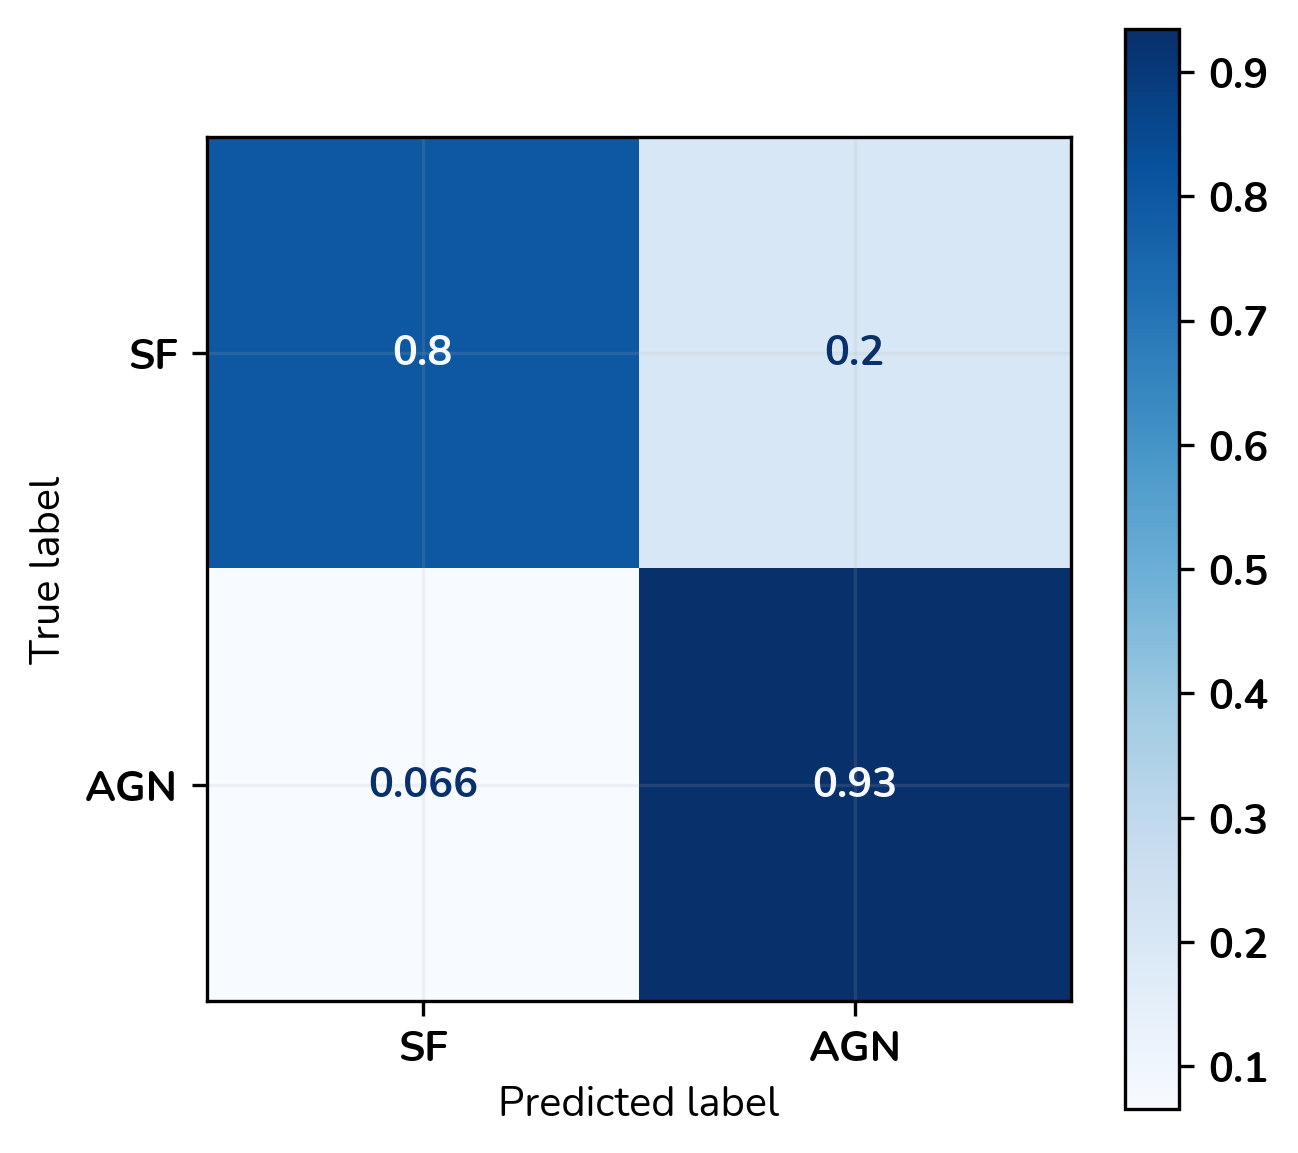

In [20]:
ConfusionMatrixDisplay.from_estimator(
    clf, 
    activations[sf_or_agn], 
    bpt_agn,
    normalize="true",
    cmap="Blues",
    display_labels=["SF", "AGN"]
)

## With only top 4 features

In [23]:
top_features = array([ 17, 138, 157, 322,])

clf.fit(
    train_activs[training_sf_or_agn][:, top_features], 
    training_agn
)

LinearSVC()

In [24]:
bpt_preds = clf.predict(activations[sf_or_agn][:, top_features])
bpt_agn = (dls.valid.items.bptclass.isin([4, 5])).values[sf_or_agn]

(
    accuracy_score(
        bpt_preds,
        bpt_agn
    ), 
    f1_score(
        bpt_preds, 
        bpt_agn
    )
)

(0.8501497077135117, 0.7196087149844376)

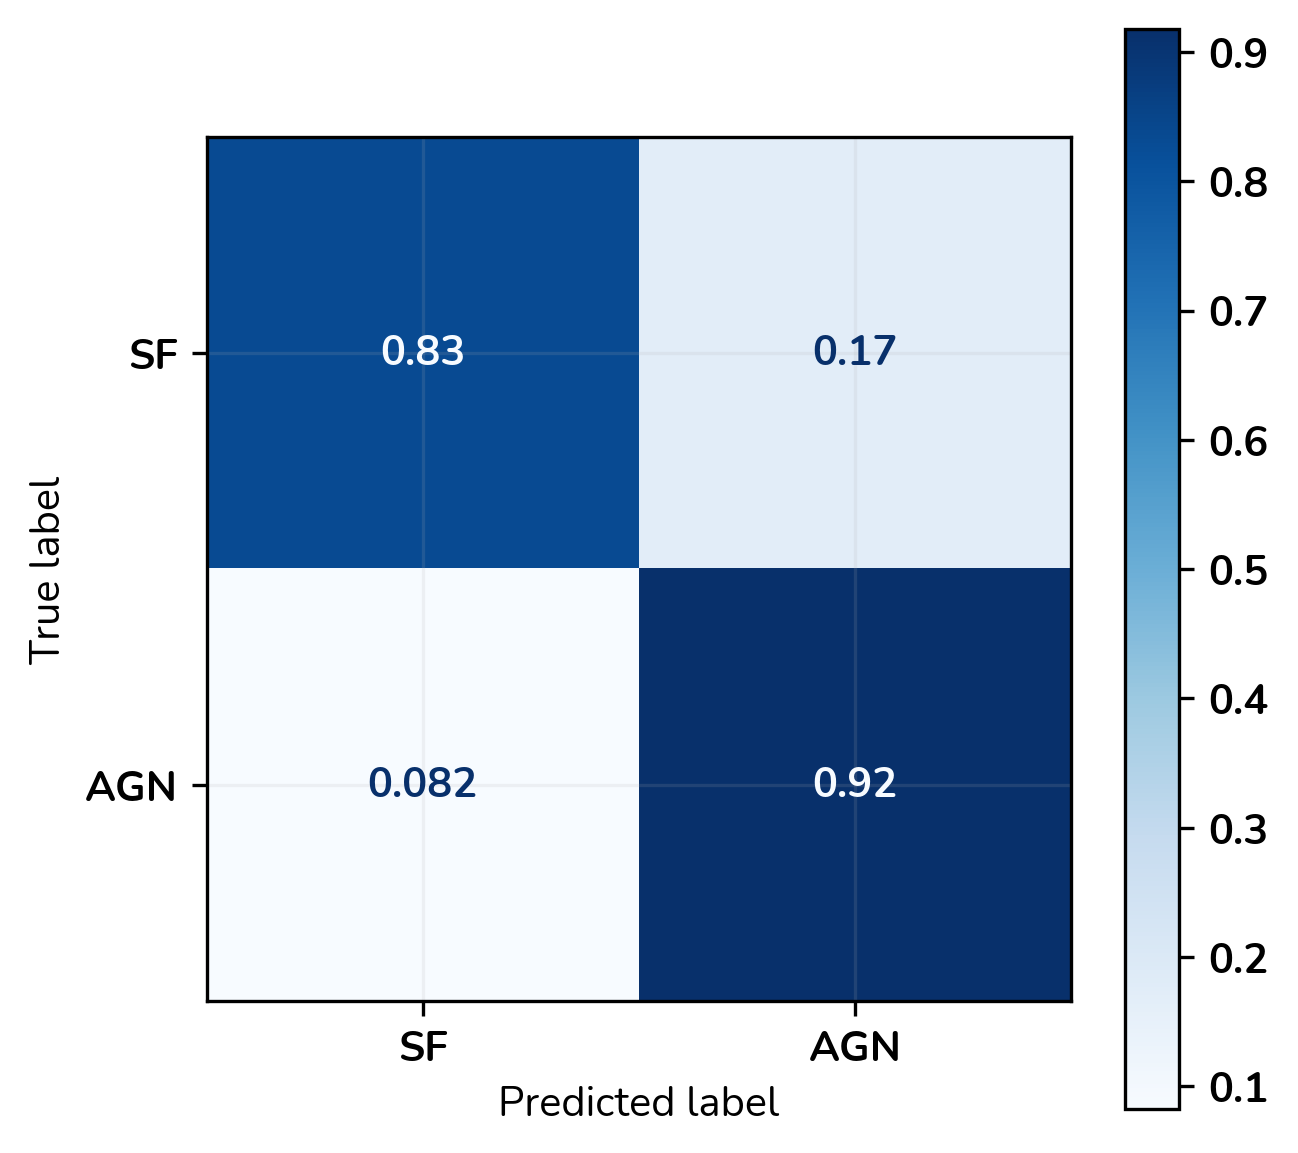

In [26]:
ConfusionMatrixDisplay.from_estimator(
    clf, 
    activations[sf_or_agn][:, top_features], 
    bpt_agn,
    normalize="true",
    cmap="Blues",
    display_labels=["SF", "AGN"]
)

## General SVC

In [ ]:
from sklearn.svm import SVC
top_features = np.array([ 17, 138, 157, 322,])


clf = SVC()
clf.fit(train_activs[training_sf_or_agn][:, top_features], training_agn)

In [ ]:
bpt_preds = clf.predict(activations[sf_or_agn][:, top_features])
bpt_agn = (dls.valid.items.bptclass.isin([4, 5])).values[sf_or_agn]


In [29]:
(
    accuracy_score(
        bpt_preds,
        bpt_agn
    ), 
    f1_score(
        bpt_preds, 
        bpt_agn
    )
)

(0.8332065966446461, 0.7007716246749371)

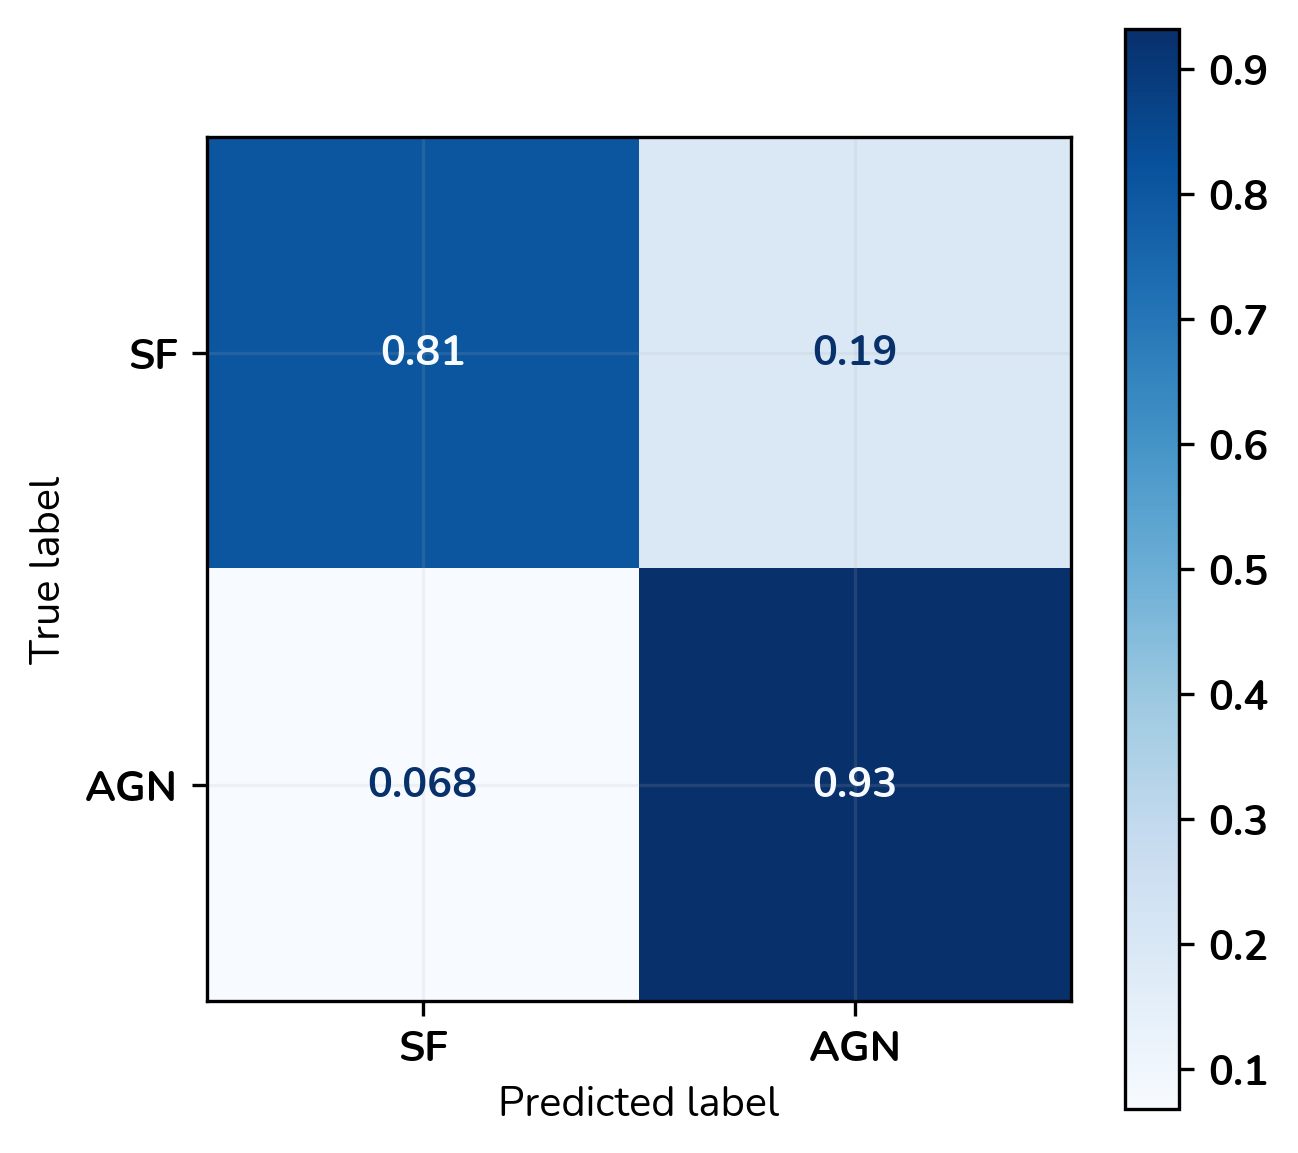

In [30]:
ConfusionMatrixDisplay.from_estimator(
    clf, 
    activations[sf_or_agn][:, top_features], 
    bpt_agn,
    normalize="true",
    cmap="Blues",
    display_labels=["SF", "AGN"]
)

# Linear combination of features to produce line ratios

In [45]:
top_features = array([ 17, 138, 157, 322,])

X_train = train_activs[:, top_features] / train_activs[:, top_features].max(0)
X_valid = activations[:, top_features] / activations[:, top_features].max(0)

y_train = np.array([
    dls.train.items.log_N2 - dls.train.items.log_Ha,
    dls.train.items.log_O3 - dls.train.items.log_Hb
]).T
y_valid = np.array([
    dls.valid.items.log_N2 - dls.valid.items.log_Ha,
    dls.valid.items.log_O3 - dls.valid.items.log_Hb
]).T

In [46]:
from sklearn.linear_model import LinearRegression

lin = LinearRegression()

lin.fit(X_train, y_train)
pred_line_ratios = lin.predict(X_valid)

In [47]:
lin.coef_, lin.intercept_

(array([[ 0.16289356, -0.28594533,  0.57347643, -1.087024  ],
        [ 0.1367473 ,  0.04947666,  0.93626034,  1.0668583 ]],
       dtype=float32),
 array([-0.34637997, -0.4832015 ], dtype=float32))

In [48]:
from sklearn.metrics import r2_score
for a in range(2):
    print("R2 score: ", r2_score(y_valid[:,a] , pred_line_ratios[:,a]))

R2 score:  0.5645333271455015
R2 score:  0.3170961417329671
